## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

In [3]:
# Dataset size
print("Number of images:", labels_df.shape[0])

Number of images: 7591


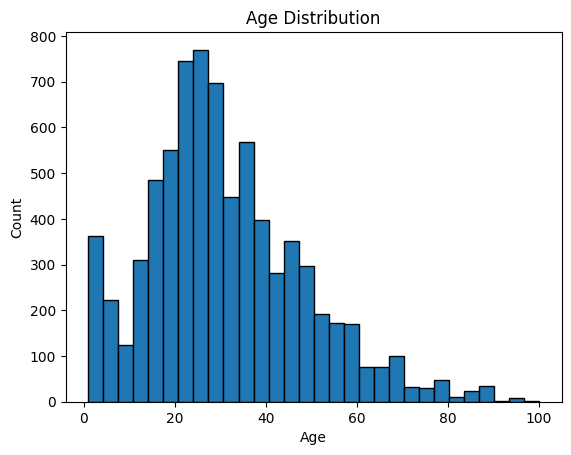

In [4]:
# Age distribution
plt.hist(labels_df['real_age'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [5]:
# import os

# image_dir = '/datasets/faces/final_files/'

# # List all entries in the directory
# all_items = os.listdir(image_dir)


# # List the first 10 entries
# print(os.listdir(image_dir)[:10])

# # Check if any are directories
# has_subfolders = any(os.path.isdir(os.path.join(image_dir, item)) for item in all_items)

# print("Contains subfolders:", has_subfolders)

In [6]:
datagen = ImageDataGenerator(
    validation_split=0.25,   # 75 % train / 25 % val, identical to Lesson 3.7
    rescale=1./255)          # normalise pixels to 0‑1

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe= labels_df,
    directory='/datasets/faces/final_files/',
    x_col= 'file_name', # feature
    y_col= 'real_age', # label/ target column
    target_size=(224, 224), #resnet50 image size
    batch_size=32,
    class_mode='raw', # regression -> raw number
    subset='training',
    seed=12345,
    shuffle=True)

val_datagen_flow = datagen.flow_from_dataframe(
    dataframe= labels_df,
    directory='/datasets/faces/final_files/',
    x_col= 'file_name', 
    y_col= 'real_age', 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='raw', 
    subset='validation',
    seed=12345,
    shuffle=False)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


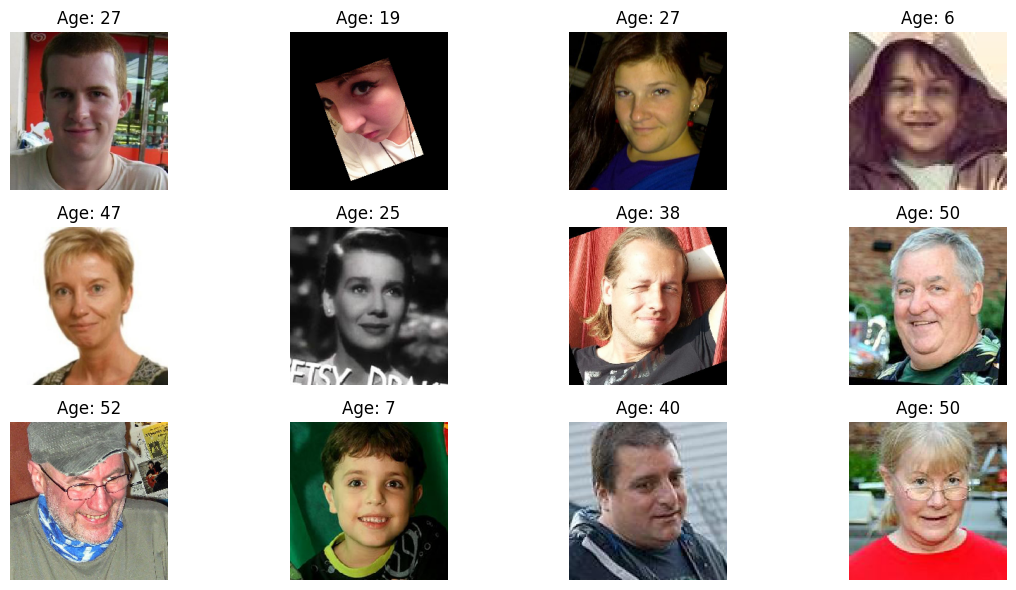

In [7]:
# Grab the next batch from the training generator
# batch_x, batch_y = next(train_datagen_flow) b
images, ages = next(train_datagen_flow)     # images shape  (16, 224, 224, 3)


# print the images
plt.figure(figsize=(12, 6))

for i in range(12):                       # 0…11
    plt.subplot(3, 4, i + 1)              # 3 rows × 4 columns
    plt.imshow(images[i])                 # show the face
    plt.title(f'Age: {int(ages[i])}')     # round to nearest int for the title
    plt.axis('off')                       # hide axes ticks

plt.tight_layout()
plt.show()

### Findings

**From the Age Distribution histogram:** Most individuals are aged 20–40, with relatively few images under age 10 or over 70. This skewed distribution may lead the model to perform best on young adults while struggling with children and older adults. 

**The sample images** show a range of facial appearances and different levels of lighting. Some images have glasses or hats, which might be challenging for the model. Overall, the images are close-ups, reasonably clean and well-aligned. 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    
    Creating the training subset and returning a generator, not arrays
    """
    
    labels_df = pd.read_csv('/datasets/faces/labels.csv')
    
    datagen = ImageDataGenerator(
    validation_split=0.25,   # 75 % train / 25 % val, identical to Lesson 3.7
    rescale=1./255)          # normalise pixels to 0‑1

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe= labels_df,
        directory='/datasets/faces/final_files/',
        x_col= 'file_name', # feature
        y_col= 'real_age', # label/ target column
        target_size=(224, 224), #resnet50 image size
        batch_size=32,
        class_mode='raw', # regression -> raw number
        subset='training',
        seed=12345,
        shuffle=True)
    

    return train_gen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels_df = pd.read_csv('/datasets/faces/labels.csv')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',  
        seed=12345,
        shuffle=False          # <-- don't shuffle test results = reproducible
    )

    
    return test_gen_flow

In [10]:
def create_model(input_shape):
    """
    Define the model - ResNet50
    """
    
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    model = Sequential()
    
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
              
              
    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    model.summary()
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch, # generator already knows how many batches
        validation_steps=validation_steps, # how many validation batches per epoch
        verbose=2
    )

    return model

In [12]:
# # Run from the notebook
# train_data = load_train('/datasets/faces/')
# val_data = load_test('/datasets/faces/')
# model = create_model((224, 224, 3))
# model = train_model(model, train_data, val_data, epochs=20)

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [13]:
# prepare a script to run on the GPU platform

# Imports
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

# Run the functions
run_block = """
if __name__ == '__main__':
    train_data = load_train('/datasets/faces/')
    val_data = load_test('/datasets/faces/')
    model = create_model((224, 224, 3))
    model = train_model(model, train_data, val_data, epochs=20)
"""

import inspect

# Create the python script
with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str) # add imports
    f.write('\n\n')
    
    # Define the functions
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
    
    f.write(run_block)

In [14]:
#%run run_model_on_gpu.py

### Output

Place the output from the GPU platform as an Markdown cell here.

```
Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512
```

## Conclusions

The model achieved a final validation MAE of **7.65**, which satisfies the project requirement. 

The validation MAE steadily declined, indicating that the model was able to learn meaningful patterns from the data and generalize well. 

The chosen architecture using ResNet50 with a regression head proved effective for predicting age from facial images.


### Can computer vision help the customer in this case?

Yes, computer vision can definitely help here. The model is able to estimate a person’s age from a facial image, which means it could support staff at the checkout by flagging customers who might be underage. This doesn’t replace ID checks, but it adds a helpful layer of automation to reduce the chances of selling alcohol to minors — and helps stores stay compliant with the law.

### What else could the customer do with a model like this?

There are a few interesting ways the store could put this kind of model to work:

- **Understand customer demographics** – anonymized age estimates could help stores learn more about who’s shopping when, and tailor inventory or promotions accordingly.
- **Personalized experiences** – the system could adjust digital signage or recommend products based on broad age ranges (without storing personal data).
- **Staff planning and layout decisions** – by analyzing foot traffic and customer age groups, stores could optimize staffing or tweak how they lay out certain sections.

This kind of model has potential beyond just checking IDs — it could offer useful insights that help the business run more smoothly and serve customers better.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training